In [1]:
from agents import DPM_Agent, agent_loss, sampled_agent_reward
from trading_env.environment import TradingEnv

import random
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

## Construct Synthetic data

In [2]:
data_length = 100
NOISE = .05
NUM_RATES = 4
time_array = np.linspace(0,data_length-1,data_length)

r = np.logspace( -4, -2, NUM_RATES)
rates = np.concatenate((-r,r),axis = 0)

N_STOCKS = len(rates)

def synth_data():

    rates_v_time =  np.outer(rates,time_array) * (1 +  np.random.normal(0, NOISE, size = (N_STOCKS,data_length)) )

    return np.exp(np.stack([rates_v_time,rates_v_time],axis = 2))

synth_train_data = synth_data()

synth_validation_data = synth_data()


### Synthetic data visualization

We have constructed 8 noisy exponential series. The agent should learn to differentiate between these series and invest in the series offering the highest reward.

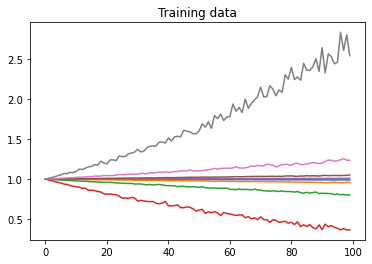

In [3]:
for k in range(8):
    plt.plot(synth_train_data[k,:,0])
plt.title('Training data')
plt.show()

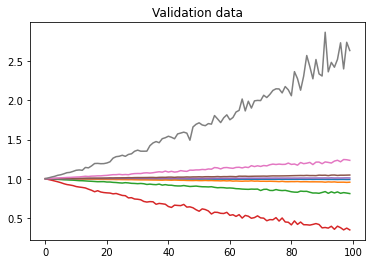

In [4]:
for k in range(8):
    plt.plot(synth_validation_data[k,:,0])
plt.title('Validation data')
plt.show()

In [5]:
agent = DPM_Agent()
train_env = TradingEnv(synth_train_data)
val_env = TradingEnv(synth_validation_data)

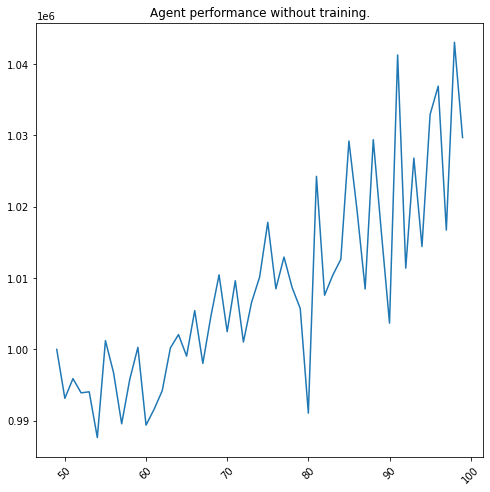

Initial value of portfolio:  1000000.0
Final value of portfolio:  1029693.56
Maximum value of portfolio:  1043045.25
Minimum value of portfolio:  987634.6


In [6]:
# Simulate untrained agent to view baseline
loss = agent_loss(val_env,agent)
plt.figure(figsize=(8,8))
plt.plot(time_array[49:], val_env.portfolio_value_hist)
plt.xticks(rotation=45)
plt.title('Agent performance without training.')
plt.show()
portfolio_vals = val_env.portfolio_value_hist
print('Initial value of portfolio: ',portfolio_vals[0].numpy())
print('Final value of portfolio: ', portfolio_vals[-1].numpy())
print('Maximum value of portfolio: ',max(portfolio_vals).numpy())
print('Minimum value of portfolio: ',min(portfolio_vals).numpy())

In [7]:
TRADING_DAYS_PER_YEAR = 253

def train_step(agent,batch):
    """Runs a model training step."""
    env = TradingEnv(batch,train_noise=0.2)
 
    with tf.GradientTape() as tape:
        tape.watch(agent.model.trainable_variables)
        loss = agent_loss(env,agent,dsct = 0.99)

        grad = tape.gradient(loss,agent.model.trainable_variables)
        grad = [g / tf.reduce_mean(tf.abs(g)) for g in grad]
        agent.opt.apply_gradients(zip(grad,agent.model.trainable_variables))

    reward = -TRADING_DAYS_PER_YEAR * loss/(env._end_tick-env._start_tick)

    return reward

In [8]:
def Callback_EarlyStopping(RewardsList, min_delta=0, patience=30):
    
    if RewardsList[-1] != RewardsList[-1]:
        print('NAN error')
        return True   


    #No early stopping for 3*patience epochs 
    if len(RewardsList)//patience < 3 :
        return False
    #Mean loss for last patience epochs and second-last patience epochs
    mean_previous = np.mean(RewardsList[::-1][2*patience:3*patience]) #third-last
    mean_recent = np.mean(RewardsList[::-1][:patience]) #last
    #you can use relative or absolute change
    delta = mean_recent - mean_previous # change
    percent_delta = delta / mean_previous  # relative change
    if percent_delta < min_delta : 
        print(f"*CB_ES* Percent change in reward value: {percent_delta*1e2:.4f}")
        return True 
    else:
        return False

In [9]:
train_rewards = [] 
validation_rewards = []
MAX_EPOCHS = 100 
for epoch in range(MAX_EPOCHS):

    reward = train_step(agent,synth_train_data)
            
  
    sar = sampled_agent_reward(TradingEnv,synth_train_data,[agent],N_STOCKS,1,dsct = 1)
    train_rewards.append(np.mean(sar[agent.name]))
    sar = sampled_agent_reward(TradingEnv,synth_validation_data,[agent],N_STOCKS,1,dsct = 1)
    validation_rewards.append(np.mean(sar[agent.name]))

    if Callback_EarlyStopping(train_rewards):
        break

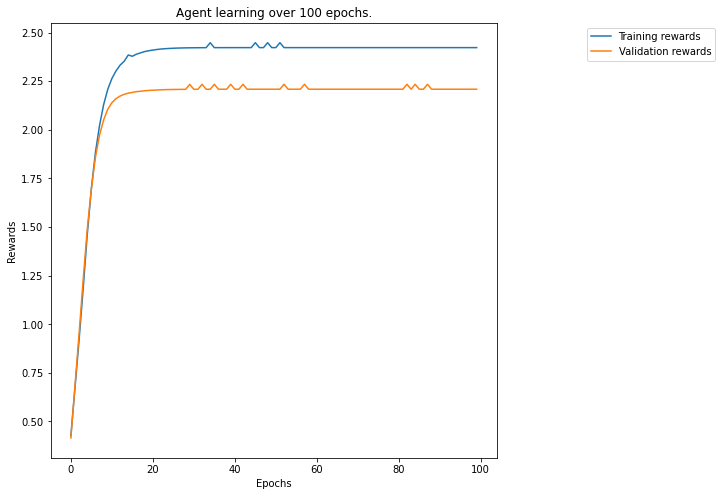

In [10]:
plt.figure(figsize=(8,8))
plt.plot(train_rewards,label = 'Training rewards') 
plt.plot(validation_rewards, label = 'Validation rewards') 
plt.legend(loc='upper right',bbox_to_anchor=(1.5, 1) )
plt.title(f'Agent learning over {epoch+1} epochs.')
plt.xlabel('Epochs')
plt.ylabel('Rewards')
plt.show()

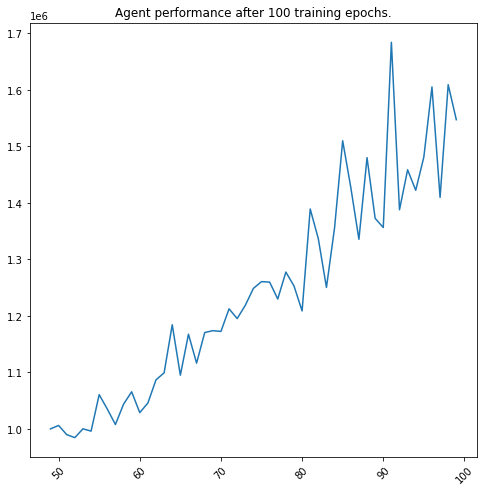

Initial value of portfolio:  1000000.0
Final value of portfolio:  1547277.0
Maximum value of portfolio:  1684350.4
Minimum value of portfolio:  984532.56


In [11]:
# Simulate trained agent to view behavior after training
loss = agent_loss(val_env,agent,dsct = .99)
plt.figure(figsize=(8,8))
plt.plot(time_array[49:], val_env.portfolio_value_hist)
plt.xticks(rotation=45)
plt.title(f'Agent performance after {epoch+1} training epochs.')
plt.show()
print('Initial value of portfolio: ',val_env.portfolio_value_hist[0].numpy())
print('Final value of portfolio: ',val_env.portfolio_value_hist[-1].numpy())
print('Maximum value of portfolio: ',max(val_env.portfolio_value_hist).numpy())
print('Minimum value of portfolio: ',min(val_env.portfolio_value_hist).numpy())

In [12]:
percent_return = 100* ((val_env.portfolio_value_hist[-1] -val_env.portfolio_value_hist[0]) /val_env.portfolio_value_hist[0]).numpy()

print(f'The agent traded on 50 days and earned {percent_return:.2f}% return.')

The agent traded on 50 days and earned 54.73% return.



### This is (approximately) the maximum possible return, demonstrating the agent is capable of learning correctly on well behaved data.